<a href="https://colab.research.google.com/github/nyp-sit/sdaai-iti103/blob/master/session-7/imb_methods_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Methods for Tackling Imbalanced Data

In this notebook, we will compare the performance of different methods on different imbalanced datasets:

- just re-sampling
- just boosting or bagging
- bagging + re-sampling
- boosting + re-sampling
- bagging + boosting + re-sampling



In [1]:
#You will get the error such as below:

#AttributeError: 'EasyEnsembleClassifier' object has no attribute 'n_features_in_'

#Please downgrade your sklearn library to version 1.0 using the following code:
#The attribute n_features_in_ is deprecated and its support was lost in sklearn version 1.2
#You will need to restart the runtime after the install

!pip install scikit-learn==1.0.0
# You may also check the sklearn version by using:
import sklearn
print(sklearn.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-learn: filename=scikit_learn-1.0-cp310-cp310-linux_x86_64.whl size=25849309 sha256=7efcc8520067b74afe89f51a02ef2ae825edd5aab658ef35d6be4ba14fbbdeb4
  Stored in directory: /root/.cache/pip/wheels/dc/ac/81/f7dc596b727fdedc2b8f05ef115393b07478ee09a76edebdff
Successfully built scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.10.

In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
)

import xgboost

from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from imblearn.datasets import fetch_datasets

from imblearn.under_sampling import (
    RandomUnderSampler,
    TomekLinks,
    EditedNearestNeighbours
)

from imblearn.combine import SMOTEENN

from imblearn.over_sampling import SMOTE

from imblearn.ensemble import (
    BalancedBaggingClassifier,
    BalancedRandomForestClassifier,
    RUSBoostClassifier,
    EasyEnsembleClassifier,
)


We create a dictionary to store our different re-samplers we want to try out.

In [2]:
# just re-sampling methods (no classifier)

resampling_dict = {

    # Undersampling
    'random': RandomUnderSampler(
        sampling_strategy='auto',
        random_state=0,
        replacement=False,
    ),

    # Undersampling
    'tomek': TomekLinks(
        sampling_strategy='majority',
        n_jobs=4),

    # Oversampling
    'smote': SMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=5,
        n_jobs=4),

    # Oversampling + Undersampling
    'smenn': SMOTEENN(
        sampling_strategy='auto',
        random_state=0,
        smote=SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=5),
        enn=EditedNearestNeighbours(
            sampling_strategy='auto', n_neighbors=3, kind_sel='all'),
        n_jobs=4),

}

We create another dictionary to store the different ensemble methods we want to try out.

In [11]:
# ensemble methods (with or without resampling)

ensemble_dict = {

    # bagging of Logistic regression, no resampling
    'bagging': BaggingClassifier(
        base_estimator=LogisticRegression(random_state=2909),
        n_estimators=20,
        n_jobs=4,
        random_state=0,
    ),

    # balanced random forests (bagging)
    'balancedRF': BalancedRandomForestClassifier(
        n_estimators=20,
        criterion='gini',
        max_depth=3,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=0,
    ),

    # bagging of Logistic regression, with resampling
    'balancedbagging': BalancedBaggingClassifier(
        base_estimator=LogisticRegression(random_state=2909),
        n_estimators=20,
        max_samples=1.0,  # The number of samples to draw from X to train each base estimator
        max_features=1.0,  # The number of features to draw from X to train each base estimator
        bootstrap=True,
        bootstrap_features=False,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=0,
    ),

    # boosting + undersampling
    'rusboost': RUSBoostClassifier(
        estimator=None,
        n_estimators=20,
        learning_rate=1.0,
        sampling_strategy='auto',
        random_state=0,
    ),

    # bagging + boosting + under-sammpling
    'easyEnsemble': EasyEnsembleClassifier(
        n_estimators=20,
        sampling_strategy='auto',
        n_jobs=4,
        random_state=0,
    ),
}

We want to test our different methods on different imbalanced datasets provided by imblearn. We also print out the distribution between positive (1) class and negative (-1) class.

In [4]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})

thyroid_sick
Counter({-1: 3541, 1: 231})

arrhythmia
Counter({-1: 427, 1: 25})

ozone_level
Counter({-1: 2463, 1: 73})



In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=20, random_state=0, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    probas = rf.predict_proba(X_train)
    preds = probas[:,1]
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = rf.predict_proba(X_test)
    preds = probas[:,1]
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [6]:
# function to train adaboost and evaluate the performance

def run_adaboost(X_train, X_test, y_train, y_test):

    ada = AdaBoostClassifier(n_estimators=20, random_state=0)

    ada.fit(X_train, y_train)

    print('Train set')
    probas = ada.predict_proba(X_train)
    preds = probas[:,1]
    print('AdaBoost roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = ada.predict_proba(X_test)
    preds = probas[:,1]
    print('AdaBoost roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [7]:
# function to train xgboost and evaluate the performance

def run_xgboost(X_train, X_test, y_train, y_test):

    xgb = xgboost.XGBClassifier(use_label_encoder=False, random_state=0)

    xgb.fit(X_train, y_train)

    print('Train set')
    probas = xgb.predict_proba(X_train)
    preds = probas[:,1]
    print('XGBoost roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = xgb.predict_proba(X_test)
    preds = probas[:,1]
    print('XGBoost roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [8]:
# function to train random forests and evaluate the peensembleormance

def run_ensemble(ensemble, X_train, X_test, y_train, y_test):

    ensemble.fit(X_train, y_train)

    print('Train set')
    probas = ensemble.predict_proba(X_train)
    preds = probas[:,1]
    print(
        'ensemble roc-auc: {}'.format(roc_auc_score(y_train, preds)))

    print('Test set')
    probas = ensemble.predict_proba(X_test)
    preds = probas[:,1]
    print(
        'ensemble roc-auc: {}'.format(roc_auc_score(y_test, preds)))

    return roc_auc_score(y_test, preds)

In [12]:
# to save the results
results_dict = {}

for dataset in datasets_ls:

    results_dict[dataset] = {}
    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]
    X = data.data
    y = data.target

    # convert -1 to 0, so that it can work with xgboost

    my_dict = {-1:0, 1:1}
    y = np.vectorize(my_dict.get)(y)

    # separate train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,random_state=0)

    # we set variables in the same scale as many re-sampling techniques use KNN
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    # train model and store result
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data'] = roc
    print()

    # train model and store result
    roc = run_adaboost(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data_adaboost'] = roc
    print()

    roc = run_xgboost(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data_xgboost'] = roc
    print()

    for sampler in resampling_dict.keys():

        print(sampler)

        # resample
        X_resampled, y_resampled = resampling_dict[sampler].fit_resample(X_train, y_train)

        # train model and store result
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        results_dict[dataset][sampler] = roc
        print()

    for ensemble in ensemble_dict.keys():

        print(ensemble)

        # train model and store result
        roc = run_ensemble(ensemble_dict[ensemble], X_train, X_test, y_train, y_test)
        results_dict[dataset][ensemble] = roc
        print()


car_eval_34
Train set
Random Forests roc-auc: 0.9550558915154848
Test set
Random Forests roc-auc: 0.9487983281086729

Train set
AdaBoost roc-auc: 0.9986549386109583
Test set
AdaBoost roc-auc: 0.9961105305932892



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train set
XGBoost roc-auc: 1.0
Test set
XGBoost roc-auc: 0.9987228607918263

random
Train set
Random Forests roc-auc: 0.9985151541619356
Test set
Random Forests roc-auc: 0.975908510391269

tomek
Train set
Random Forests roc-auc: 0.9542684053045695
Test set
Random Forests roc-auc: 0.9512365029606409

smote


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9865974625144176
Test set
Random Forests roc-auc: 0.9714965749448508

smenn
Train set
Random Forests roc-auc: 0.9952612072279893
Test set
Random Forests roc-auc: 0.9874608150470219

bagging
Train set
ensemble roc-auc: 0.9987538940809969
Test set
ensemble roc-auc: 0.997561825148032

balancedRF
Train set
ensemble roc-auc: 0.9909913872090892
Test set
ensemble roc-auc: 0.9909439219784046

balancedbagging


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Train set
ensemble roc-auc: 0.9988491845336266
Test set
ensemble roc-auc: 0.9974457215836525

rusboost
Train set
ensemble roc-auc: 0.997108301264431
Test set
ensemble roc-auc: 0.9964588412864275

easyEnsemble
Train set
ensemble roc-auc: 0.9990251053692505
Test set
ensemble roc-auc: 0.9966329966329966

ecoli
Train set
Random Forests roc-auc: 0.9565126050420169
Test set
Random Forests roc-auc: 0.9968253968253967

Train set
AdaBoost roc-auc: 0.9913865546218488
Test set
AdaBoost roc-auc: 0.9587301587301587

Train set
XGBoost roc-auc: 1.0
Test set
XGBoost roc-auc: 0.9904761904761905

random
Train set
Random Forests roc-auc: 0.9855555555555556
Test set
Random Forests roc-auc: 0.9603174603174603

tomek
Train set


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Random Forests roc-auc: 0.9711206896551724
Test set
Random Forests roc-auc: 0.9873015873015872

smote
Train set
Random Forests roc-auc: 0.9654420591766117
Test set
Random Forests roc-auc: 0.9793650793650793

smenn
Train set
Random Forests roc-auc: 0.9580828020863518
Test set
Random Forests roc-auc: 0.9841269841269841

bagging
Train set
ensemble roc-auc: 0.9354341736694678
Test set
ensemble roc-auc: 0.9746031746031746

balancedRF
Train set
ensemble roc-auc: 0.9710784313725489
Test set
ensemble roc-auc: 0.9714285714285714

balancedbagging


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Train set
ensemble roc-auc: 0.926750700280112
Test set
ensemble roc-auc: 0.9650793650793651

rusboost
Train set
ensemble roc-auc: 0.9602941176470587
Test set
ensemble roc-auc: 0.9650793650793651

easyEnsemble
Train set
ensemble roc-auc: 0.9876750700280111
Test set
ensemble roc-auc: 0.9809523809523809

thyroid_sick
Train set
Random Forests roc-auc: 0.9558640796219966
Test set
Random Forests roc-auc: 0.9791027999182506

Train set
AdaBoost roc-auc: 0.991512013672464
Test set
AdaBoost roc-auc: 0.9645156345800123



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train set
XGBoost roc-auc: 1.0
Test set
XGBoost roc-auc: 0.9979307173513182

random
Train set
Random Forests roc-auc: 0.9635102040816326
Test set
Random Forests roc-auc: 0.978489679133456

tomek
Train set
Random Forests roc-auc: 0.9582366707366707
Test set
Random Forests roc-auc: 0.9802651747394237

smote
Train set
Random Forests roc-auc: 0.9542320604623222
Test set
Random Forests roc-auc: 0.9650648886163908

smenn


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.952830227970078
Test set
Random Forests roc-auc: 0.9682454526875127

bagging
Train set
ensemble roc-auc: 0.9317241379310345
Test set
ensemble roc-auc: 0.933910688739015

balancedRF
Train set
ensemble roc-auc: 0.9628541268724238
Test set
ensemble roc-auc: 0.9776721847537297

balancedbagging


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Train set
ensemble roc-auc: 0.9084347039308334
Test set
ensemble roc-auc: 0.9169476803596974

rusboost
Train set
ensemble roc-auc: 0.9810053282396702
Test set
ensemble roc-auc: 0.9557914367463725

easyEnsemble
Train set
ensemble roc-auc: 0.98746958882075
Test set
ensemble roc-auc: 0.9613478438585733

arrhythmia
Train set
Random Forests roc-auc: 0.9931372549019607
Test set
Random Forests roc-auc: 0.9511494252873564

Train set
AdaBoost roc-auc: 1.0
Test set
AdaBoost roc-auc: 1.0



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train set
XGBoost roc-auc: 1.0
Test set
XGBoost roc-auc: 0.9971264367816092

random
Train set
Random Forests roc-auc: 0.9977324263038548
Test set
Random Forests roc-auc: 0.7298850574712643

tomek
Train set
Random Forests roc-auc: 0.9937079937079937
Test set
Random Forests roc-auc: 0.9454022988505747

smote


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9956401384083045
Test set
Random Forests roc-auc: 0.9137931034482759

smenn
Train set
Random Forests roc-auc: 0.9945155709342561
Test set
Random Forests roc-auc: 0.8620689655172413

bagging
Train set
ensemble roc-auc: 0.9822128851540617
Test set
ensemble roc-auc: 0.8563218390804598

balancedRF
Train set
ensemble roc-auc: 0.9931372549019608
Test set
ensemble roc-auc: 0.942528735632184

balancedbagging


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Train set
ensemble roc-auc: 0.9512605042016807
Test set
ensemble roc-auc: 0.7844827586206896

rusboost
Train set
ensemble roc-auc: 0.9941176470588234
Test set
ensemble roc-auc: 0.9899425287356322

easyEnsemble
Train set
ensemble roc-auc: 1.0
Test set
ensemble roc-auc: 0.985632183908046

ozone_level
Train set
Random Forests roc-auc: 0.8915184620596207
Test set
Random Forests roc-auc: 0.8502719502719502

Train set
AdaBoost roc-auc: 0.983422256097561
Test set
AdaBoost roc-auc: 0.8749028749028749



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Train set
XGBoost roc-auc: 1.0
Test set
XGBoost roc-auc: 0.9205905205905206

random
Train set
Random Forests roc-auc: 0.9352777777777778
Test set
Random Forests roc-auc: 0.8573426573426574

tomek
Train set
Random Forests roc-auc: 0.8910272804774084
Test set
Random Forests roc-auc: 0.8634032634032633

smote
Train set
Random Forests roc-auc: 0.9337277538171724
Test set
Random Forests roc-auc: 0.7902097902097902

smenn


/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train set
Random Forests roc-auc: 0.9357814462290964
Test set
Random Forests roc-auc: 0.8059829059829059

bagging
Train set
ensemble roc-auc: 0.9460704607046071
Test set
ensemble roc-auc: 0.9041181041181042

balancedRF
Train set
ensemble roc-auc: 0.9482342479674797
Test set
ensemble roc-auc: 0.8654234654234654

balancedbagging


/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_bagging.py:353: FutureWarning: `base_estimator` was renamed to `estimator` in version 0.10 and will be removed in 0.12.
  warnings.warn(


Train set
ensemble roc-auc: 0.928539972899729
Test set
ensemble roc-auc: 0.8890442890442891

rusboost
Train set
ensemble roc-auc: 0.952074864498645
Test set
ensemble roc-auc: 0.8449106449106448

easyEnsemble
Train set
ensemble roc-auc: 0.9855098238482385
Test set
ensemble roc-auc: 0.8937062937062937



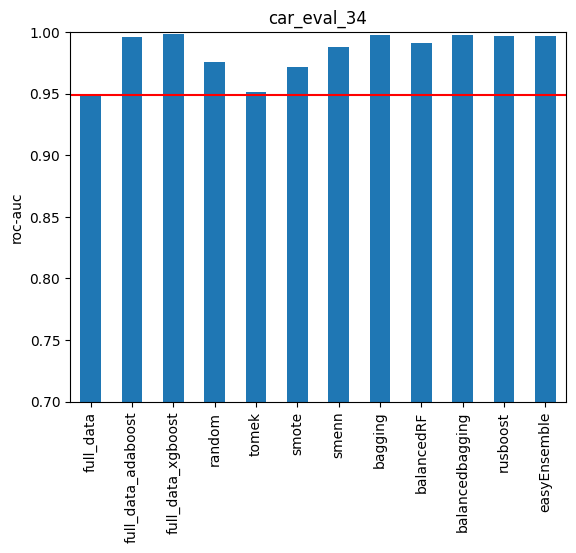

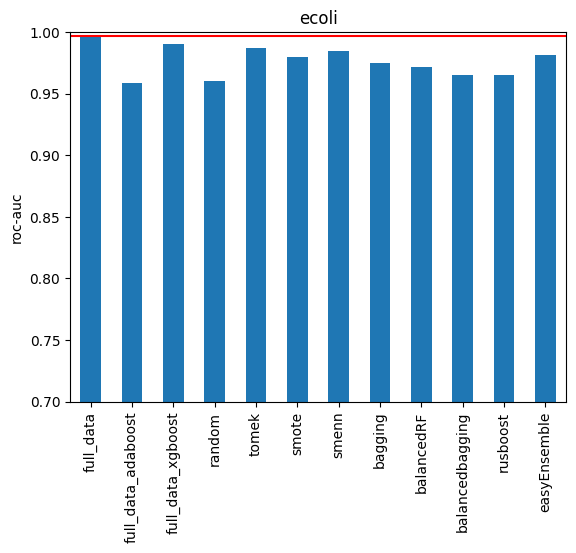

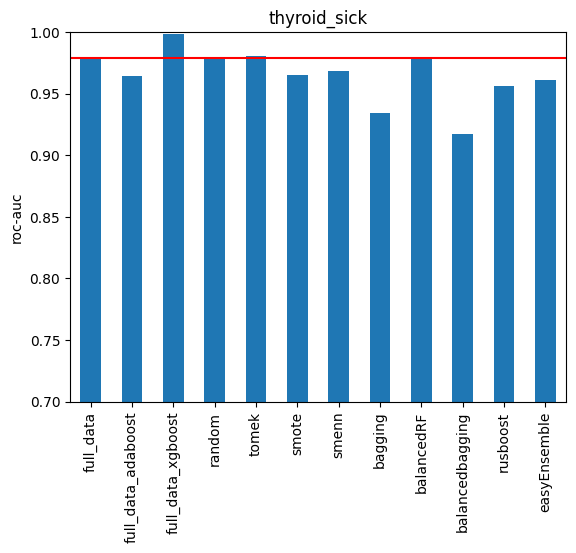

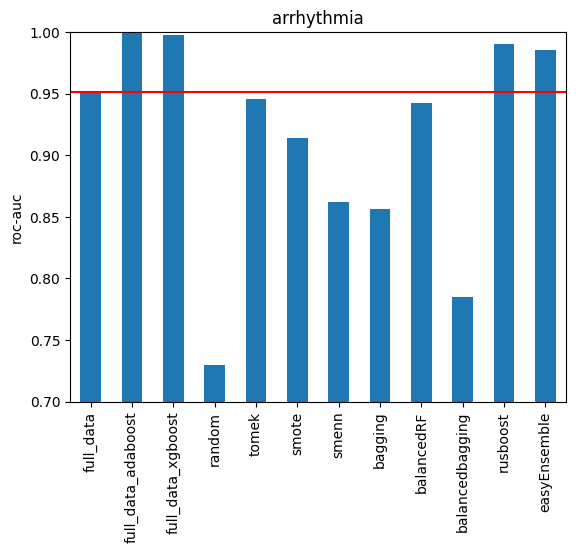

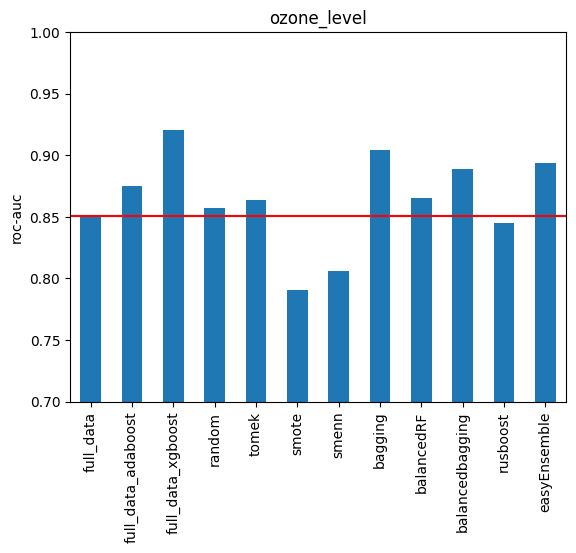

In [13]:
for dataset in datasets_ls:

    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.7, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

We see that boosting algorithms tend to outperform bagging algorithms. And adding resampling to bagging improves performance, in general, quite a bit.

We also see that in some cases, boosting alone outperforms resampling techniques.

Different methods has different performance on different datasets. There is no a single method that is best for all datasets.
